### Expérimentation et sélection de modèles pour la prédiction des prix des maisons

Ce notebook présente la phase d'expérimentation et de sélection des modèles de machine learning pour la prédiction des prix des maisons à Ames, Iowa. Il s'appuie sur les résultats de l'analyse exploratoire pour construire, entraîner et évaluer différents modèles de régression.

### Objectifs de l'expérimentation :

- Préparation des données : Nettoyage, transformation et préparation du jeu de données pour la modélisation
  
- Construction du pipeline de prétraitement : Mise en place d'un pipeline robuste pour le traitement des données
  
- Expérimentation de modèles : Test de différents algorithmes de régression

- Évaluation et comparaison : Analyse des performances avec des métriques appropriées

- Suivi avec MLFlow : Enregistrement des expériences pour la traçabilité

- Sélection du modèle final : Choix du meilleur modèle basé sur les performances
  
- Analyse des résidus** : Validation des hypothèses du modèle sélectionné
  
- Sauvegarde du modèle : Préparation pour le déploiement


### Importation des librairies

Cette section importe toutes les bibliothèques Python nécessaires pour la manipulation des données, le machine learning, la visualisation et le suivi des expériences avec MLFlow. Nous incluons également des configurations pour les avertissements, le logging et les paramètres graphiques afin d'assurer un environnement de travail cohérent et informatif.

In [1]:
# Librairies pour la manipulation des données
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import json
import pickle

# Librairies pour le machine learning
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modèles de régression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
)
from sklearn.svm import SVR
from xgboost import XGBRegressor  # Ajout de XGBoost

# Métriques d'évaluation
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# Librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# MLFlow pour le suivi des expériences
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Librairies pour le logging et la configuration
from loguru import logger
import sys
import pendulum
from scipy import stats

warnings.filterwarnings("ignore")

# Configuration du logger
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# Configuration des graphiques
plt.style.use("default")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Variables globales
CURRENT_DATE = pendulum.now(tz="UTC")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

logger.info("Toutes les librairies ont été importées avec succès")

2025-07-31 23:06:31.758 | INFO     | __main__:<module>:69 - Toutes les librairies ont été importées avec succès


### Configuration des chemins et paramètres

Cette section est dédiée à la configuration des chemins d'accès aux données et aux répertoires de sortie, ainsi qu'à la définition des paramètres globaux pour l'expérimentation. Nous nous assurons que tous les répertoires nécessaires existent et configurons MLFlow pour le suivi des expériences, garantissant ainsi la reproductibilité et l'organisation de notre travail.

In [2]:
# Définition des chemins
path = Path.cwd()
while not (path / "notebooks").exists() or not (path / "house_price_dataset").exists():
    if path == path.parent:
        raise FileNotFoundError("Impossible de trouver la racine du projet.")
    path = path.parent

PROJECT_DIR = path
NOTEBOOKS_DIR = PROJECT_DIR / "notebooks"
DATA_DIR = PROJECT_DIR / "house_price_dataset"
OUTPUT_DIR = NOTEBOOKS_DIR / "output_files"
MODELS_DIR = NOTEBOOKS_DIR / "models"
REPORTS_DIR = NOTEBOOKS_DIR / "reports"

# Création des répertoires s'ils n'existent pas
for directory in [OUTPUT_DIR, MODELS_DIR, REPORTS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Paramètres de l'expérimentation
TARGET_VARIABLE = "SalePrice"
TEST_SIZE = 0.2
CV_FOLDS = 5
FIGSIZE_LARGE = (15, 8)
FIGSIZE_MEDIUM = (12, 6)
FIGSIZE_SMALL = (10, 5)

# Configuration MLFlow
EXPERIMENT_NAME = "House Price Prediction"
mlflow.set_experiment(EXPERIMENT_NAME)

logger.info("Configuration terminée")
logger.info(f"Répertoire du projet: {PROJECT_DIR}")
logger.info(f"Répertoire des modèles: {MODELS_DIR}")
logger.info(f"Variable cible: {TARGET_VARIABLE}")
logger.info(f"Expérience MLFlow: {EXPERIMENT_NAME}")

2025-07-31 23:06:31.995 | INFO     | __main__:<module>:31 - Configuration terminée
2025-07-31 23:06:31.999 | INFO     | __main__:<module>:32 - Répertoire du projet: d:\Documents\IT\mlops_house_price_prediction
2025-07-31 23:06:31.999 | INFO     | __main__:<module>:33 - Répertoire des modèles: d:\Documents\IT\mlops_house_price_prediction\notebooks\models
2025-07-31 23:06:32.005 | INFO     | __main__:<module>:34 - Variable cible: SalePrice
2025-07-31 23:06:32.008 | INFO     | __main__:<module>:35 - Expérience MLFlow: House Price Prediction


### Chargement et préparation initiale des données

Cette section gère le chargement du jeu de données. Nous privilégions le chargement du dataset enrichi si disponible, car il contient les variables créées lors de l'analyse exploratoire. Si ce fichier n'est pas trouvé, le dataset original est utilisé. Nous chargeons également les métadonnées pour récupérer les listes de variables jugées importantes.

In [3]:
print("\n=== CHARGEMENT DES DONNÉES ===")

# Tentative de chargement du dataset enrichi depuis l'analyse exploratoire
enriched_file = OUTPUT_DIR / "house_price_01_analyse_dataset_enrichi.csv"
original_file = DATA_DIR / "ames_housing.csv"
metadata_file = OUTPUT_DIR / "house_price_01_analyse_metadata.json"

if enriched_file.exists():
    df = pd.read_csv(enriched_file)
    logger.info(f"Dataset enrichi chargé depuis: {enriched_file}")
    print(f"Dataset enrichi chargé: {df.shape[0]:,} lignes, {df.shape[1]:,} colonnes")
else:
    df = pd.read_csv(original_file)
    logger.info(f"Dataset original chargé depuis: {original_file}")
    print(f"Dataset original chargé: {df.shape[0]:,} lignes, {df.shape[1]:,} colonnes")

    # Création rapide de quelques features importantes si le dataset enrichi n'existe pas
    if "YearBuilt" in df.columns and "YrSold" in df.columns:
        df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
        logger.info("Feature 'HouseAge' créée")

    if "TotalBsmtSF" in df.columns:
        df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)
        logger.info("Feature 'HasBasement' créée")

# Vérification de la variable cible
if TARGET_VARIABLE not in df.columns:
    logger.error(f"Variable cible '{TARGET_VARIABLE}' non trouvée dans le dataset")
    raise ValueError(f"Variable cible '{TARGET_VARIABLE}' manquante")

print(f"\nVariable cible '{TARGET_VARIABLE}' - Statistiques:")
print(df[TARGET_VARIABLE].describe())

# Chargement des métadonnées de l'analyse exploratoire si disponibles
if metadata_file.exists():
    with open(metadata_file, "r") as f:
        analysis_metadata = json.load(f)
    logger.info("Métadonnées de l'analyse exploratoire chargées")

    # Utiliser les features recommandées si disponibles
    if "top_numeric_features" in analysis_metadata:
        numeric_features = analysis_metadata["top_numeric_features"]
        print(f"Features numériques recommandées trouvées: {len(numeric_features)}")
    else:
        numeric_features = df.select_dtypes(include=np.number).columns.tolist()
        numeric_features.remove("Id")
        numeric_features.remove(TARGET_VARIABLE)
        logger.warning(
            "Liste des features numériques non trouvée dans les métadonnées. Utilisation de toutes les features numériques."
        )

    if "recommended_categorical" in analysis_metadata:
        categorical_features = analysis_metadata["recommended_categorical"]
        print(
            f"Features catégorielles recommandées trouvées: {len(categorical_features)}"
        )
    else:
        categorical_features = df.select_dtypes(include="object").columns.tolist()
        logger.warning(
            "Liste des features catégorielles non trouvée dans les métadonnées. Utilisation de toutes les features catégorielles."
        )
else:
    analysis_metadata = None
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    numeric_features.remove("Id")
    numeric_features.remove(TARGET_VARIABLE)
    categorical_features = df.select_dtypes(include="object").columns.tolist()
    logger.warning(
        "Métadonnées de l'analyse exploratoire non trouvées. Utilisation de toutes les features numériques et catégorielles."
    )

# Suppression de la colonne 'Id' si elle existe et n'est pas déjà retirée
if "Id" in df.columns:
    df = df.drop("Id", axis=1)
    if "Id" in numeric_features:
        numeric_features.remove("Id")
    logger.info("Colonne 'Id' supprimée")

logger.info("Chargement des données terminé")

2025-07-31 23:06:32.231 | INFO     | __main__:<module>:10 - Dataset enrichi chargé depuis: d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_01_analyse_dataset_enrichi.csv



=== CHARGEMENT DES DONNÉES ===
Dataset enrichi chargé: 1,460 lignes, 90 colonnes

Variable cible 'SalePrice' - Statistiques:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


2025-07-31 23:06:32.296 | INFO     | __main__:<module>:38 - Métadonnées de l'analyse exploratoire chargées
2025-07-31 23:06:32.303 | INFO     | __main__:<module>:77 - Colonne 'Id' supprimée
2025-07-31 23:06:32.303 | INFO     | __main__:<module>:79 - Chargement des données terminé


Features numériques recommandées trouvées: 15
Features catégorielles recommandées trouvées: 5


Le chargement des données a réussi en utilisant le dataset enrichi, qui contient 1,460 propriétés et 90 variables. Le processus a intelligemment utilisé les métadonnées de l'analyse précédente pour se concentrer sur les 15 variables numériques et 5 variables catégorielles les plus pertinentes, ce qui permet de construire un modèle plus ciblé. La variable cible SalePrice est bien présente, avec un prix moyen de 180,921 $. Ses statistiques confirment que les données sont prêtes pour la modélisation.

### Préparation et division des données

Cette section prépare les données avant la modélisation. Une transformation logarithmique est appliquée à la variable cible `SalePrice` pour corriger son asymétrie. Nous séparons ensuite les features (X) de la variable cible (y) et divisons le dataset en ensembles d'entraînement et de test pour permettre une évaluation juste des modèles.

2025-07-31 23:06:32.376 | INFO     | __main__:<module>:18 - Transformation log(1+x) appliquée à la variable cible



=== PRÉPARATION DES DONNÉES ===
Forme des features (X): (1460, 88)
Forme de la variable cible (y): (1460,)

Distribution initiale de la variable cible:
Moyenne: $180,921.20
Médiane: $163,000.00
Écart-type: $79,442.50
Skewness: 1.883

Transformation log appliquée (skewness > 0.5)
Skewness après transformation: 0.121


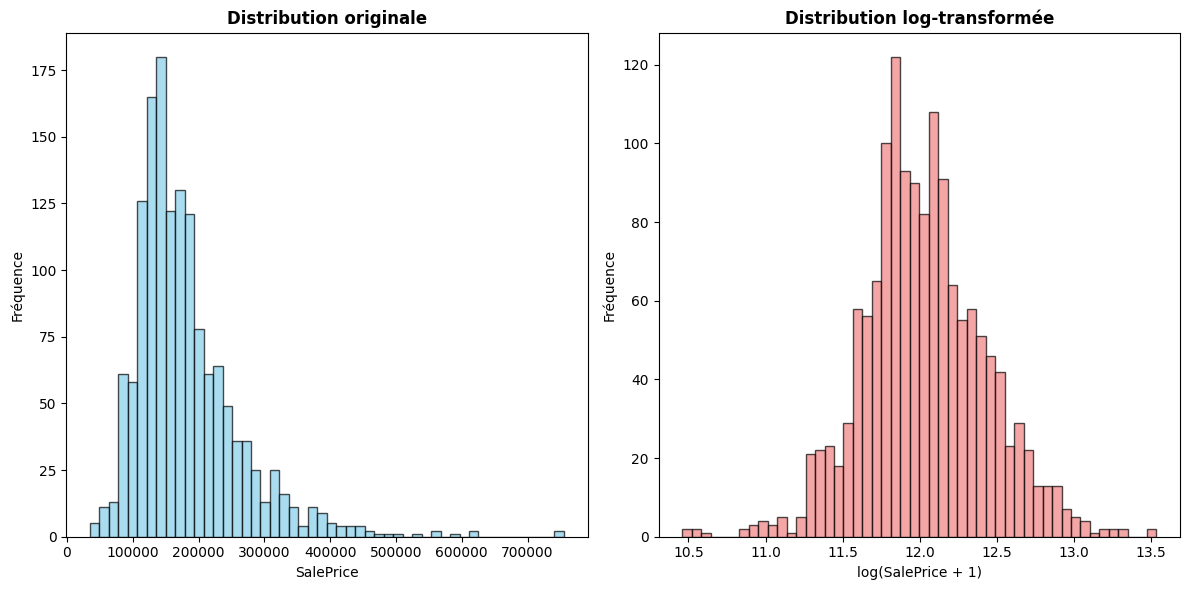

2025-07-31 23:06:35.162 | INFO     | __main__:<module>:104 - Données divisées en ensembles d'entraînement (1168 échantillons) et de test (292 échantillons)



Types de variables:
Variables numériques: 45
Variables catégorielles: 43
Utilisation des features numériques recommandées: 15
Variables catégorielles filtrées: 37

Features sélectionnées pour la modélisation: 52
- Numériques: 15
- Catégorielles: 37

Division des données:
Entraînement: 1,168 échantillons
Test: 292 échantillons
Proportion test: 20.0%


2025-07-31 23:06:35.196 | INFO     | __main__:<module>:136 - Préparation des données terminée. Features: 52, Échantillons train: 1168



Distribution de la variable cible (valeurs originales):
Moyenne: $180,921.20
Médiane: $163,000.00
Écart-type: $79,442.50
Skewness: 1.881


In [4]:
print("\n=== PRÉPARATION DES DONNÉES ===")

# Analyse initiale de la variable cible
print(f"Forme des features (X): {df.drop(columns=[TARGET_VARIABLE]).shape}")
print(f"Forme de la variable cible (y): {df[TARGET_VARIABLE].shape}")

print("\nDistribution initiale de la variable cible:")
print(f"Moyenne: ${df[TARGET_VARIABLE].mean():,.2f}")
print(f"Médiane: ${df[TARGET_VARIABLE].median():,.2f}")
print(f"Écart-type: ${df[TARGET_VARIABLE].std():,.2f}")
print(f"Skewness: {df[TARGET_VARIABLE].skew():.3f}")

# Vérification de l'asymétrie et transformation log si nécessaire
use_log_transform = False
if df[TARGET_VARIABLE].skew() > 0.5:
    df[TARGET_VARIABLE] = np.log1p(df[TARGET_VARIABLE])
    use_log_transform = True
    logger.info("Transformation log(1+x) appliquée à la variable cible")
    print("\nTransformation log appliquée (skewness > 0.5)")
    print(f"Skewness après transformation: {df[TARGET_VARIABLE].skew():.3f}")

    # Visualisation avant/après
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_MEDIUM)

    axes[0].hist(
        np.expm1(df[TARGET_VARIABLE]),
        bins=50,
        alpha=0.7,
        color="skyblue",
        edgecolor="black",
    )
    axes[0].set_title("Distribution originale", fontweight="bold")
    axes[0].set_xlabel(TARGET_VARIABLE)
    axes[0].set_ylabel("Fréquence")

    axes[1].hist(
        df[TARGET_VARIABLE], bins=50, alpha=0.7, color="lightcoral", edgecolor="black"
    )
    axes[1].set_title("Distribution log-transformée", fontweight="bold")
    axes[1].set_xlabel(f"log({TARGET_VARIABLE} + 1)")
    axes[1].set_ylabel("Fréquence")

    plt.tight_layout()
    plt.show()
else:
    logger.info(
        "Aucune transformation log appliquée à la variable cible (skewness faible)"
    )

# Séparation des features et de la variable cible
X = df.drop(TARGET_VARIABLE, axis=1)
y = df[TARGET_VARIABLE].copy()

# Identification des types de variables
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nTypes de variables:")
print(f"Variables numériques: {len(numeric_features)}")
print(f"Variables catégorielles: {len(categorical_features)}")

metadata_file = OUTPUT_DIR / "house_price_01_analyse_metadata.json"
with open(metadata_file, "r") as f:
    metadata = json.load(f)
recommended_features = metadata.get("top_numeric_features", [])

# Sélection des features recommandées si disponibles
if recommended_features:
    available_recommended = [f for f in recommended_features if f in numeric_features]
    if len(available_recommended) > 0:
        numeric_features = available_recommended
        print(
            f"Utilisation des features numériques recommandées: {len(numeric_features)}"
        )

# Filtrage des variables catégorielles (max 20 catégories, <50% de NaNs)
categorical_features_filtered = []
for col in categorical_features:
    unique_count = X[col].nunique()
    missing_pct = X[col].isnull().sum() / len(X)
    if unique_count <= 20 and missing_pct < 0.5:
        categorical_features_filtered.append(col)

categorical_features = categorical_features_filtered
print(f"Variables catégorielles filtrées: {len(categorical_features)}")

# Sélection finale des features
selected_features = numeric_features + categorical_features
X_selected = X[selected_features].copy()

print(f"\nFeatures sélectionnées pour la modélisation: {len(selected_features)}")
print(f"- Numériques: {len(numeric_features)}")
print(f"- Catégorielles: {len(categorical_features)}")

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=None,  # Pas de stratification pour la régression
)

logger.info(
    f"Données divisées en ensembles d'entraînement ({len(X_train)} échantillons) et de test ({len(X_test)} échantillons)"
)
print("\nDivision des données:")
print(f"Entraînement: {X_train.shape[0]:,} échantillons")
print(f"Test: {X_test.shape[0]:,} échantillons")
print(f"Proportion test: {X_test.shape[0] / len(X_selected):.1%}")

# Distribution de la variable cible (valeurs originales si log appliqué)
if use_log_transform:
    y_original = np.expm1(y)
    print("\nDistribution de la variable cible (valeurs originales):")
else:
    y_original = y
    print("\nDistribution de la variable cible:")

print(f"Moyenne: ${y_original.mean():,.2f}")
print(f"Médiane: ${y_original.median():,.2f}")
print(f"Écart-type: ${y_original.std():,.2f}")
print(f"Skewness: {stats.skew(y_original):.3f}")

# Sauvegarde des informations de préparation
preparation_info = {
    "target_variable": TARGET_VARIABLE,
    "use_log_transform": use_log_transform,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
    "total_features": len(selected_features),
}

logger.info(
    f"Préparation des données terminée. Features: {len(selected_features)}, Échantillons train: {X_train.shape[0]}"
)

L'asymétrie de la variable cible SalePrice est élevée (Skewness de 1.881). Une transformation logarithmique a donc été appliquée pour la corriger. L'histogramme confirme que la distribution est maintenant plus symétrique, avec un skewness réduit à 0.121, ce qui est utile pour les modèles de régression.

Après cette étape, 52 variables ont été sélectionnées pour la modélisation (15 numériques et 37 catégorielles). Les données ont ensuite été divisées en un ensemble d'entraînement de 1,168 échantillons et un ensemble de test de 292 échantillons (20% des données).

### Construction du pipeline de prétraitement

Un pipeline de prétraitement est essentiel pour gérer les différents types de variables et les valeurs manquantes de manière cohérente. Cette section construit un ColumnTransformer qui applique des transformations spécifiques à chaque type de colonne :

- Variables numériques : Imputation des valeurs manquantes par la médiane et mise à l'échelle avec RobustScaler.

- Variables catégorielles : Imputation des valeurs manquantes par une constante ('missing') et encodage avec OneHotEncoder.

In [5]:
print("\n=== CONSTRUCTION DU PIPELINE DE PRÉTRAITEMENT ===")

# Séparation des features numériques et catégorielles
# Utilisation des listes de features identifiées lors de l'analyse exploratoire
# S'assurer que les features existent dans X_train avant de les inclure
numeric_features_final = [f for f in numeric_features if f in X_train.columns]
categorical_features_final = [f for f in categorical_features if f in X_train.columns]

logger.info(
    f"Features numériques finales pour le pipeline: {len(numeric_features_final)}"
)
logger.info(
    f"Features catégorielles finales pour le pipeline: {len(categorical_features_final)}"
)

# Création des pipelines de prétraitement pour les variables numériques et catégorielles
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),  # RobustScaler pour gérer les outliers
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Création du préprocesseur combinant les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_final),
        ("cat", categorical_transformer, categorical_features_final),
    ]
)

logger.info("Pipeline de prétraitement construit avec succès")
print("Pipeline de prétraitement construit.")

2025-07-31 23:06:35.311 | INFO     | __main__:<module>:9 - Features numériques finales pour le pipeline: 15
2025-07-31 23:06:35.318 | INFO     | __main__:<module>:12 - Features catégorielles finales pour le pipeline: 37
2025-07-31 23:06:35.329 | INFO     | __main__:<module>:39 - Pipeline de prétraitement construit avec succès



=== CONSTRUCTION DU PIPELINE DE PRÉTRAITEMENT ===
Pipeline de prétraitement construit.


Un pipeline de prétraitement a été construit pour automatiser la préparation des données. Il appliquera deux traitements distincts : les 15 variables numériques verront leurs valeurs manquantes remplacées par la médiane avant d'être mises à l'échelle. De leur côté, les 37 variables catégorielles seront complétées avec le terme 'missing' puis transformées en format numérique. 

Cet outil garantit que les données d'entraînement et de test seront toujours préparées exactement de la même manière.

### Définition des modèles à tester

Cette section prépare les modèles de régression qui seront évalués. Pour chaque algorithme, nous spécifions une instance du modèle ainsi qu'une grille d’hyperparamètres à tester. Ces modèles seront intégrés à un pipeline pour permettre l’optimisation via GridSearchCV.

In [6]:
print("\n=== DÉFINITION DES MODÈLES À TESTER ===")

# Dictionnaire des modèles avec leurs grilles d'hyperparamètres
models = {
    "LinearRegression": {"model": LinearRegression(), "params": {}},
    "Ridge": {
        "model": Ridge(random_state=RANDOM_STATE),
        "params": {"model__alpha": [0.1, 1.0, 10.0]},
    },
    "Lasso": {
        "model": Lasso(random_state=RANDOM_STATE),
        "params": {"model__alpha": [0.0001, 0.001, 0.01, 0.1]},
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=RANDOM_STATE),
        "params": {
            "model__alpha": [0.0001, 0.001, 0.01],
            "model__l1_ratio": [0.1, 0.5, 0.9],
        },
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [10, 20, None],
        },
    },
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
        },
    },
    "ExtraTreesRegressor": {
        "model": ExtraTreesRegressor(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [10, 20, None],
        },
    },
    "SVR": {
        "model": SVR(),
        "params": {"model__C": [0.1, 1, 10], "model__epsilon": [0.01, 0.1, 0.2]},
    },
    "XGBRegressor": {
        "model": XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror"),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [3, 5],
        },
    },
}

print(f"Nombre de modèles définis: {len(models)}")
for name, config in models.items():
    print(f"- {name}: {len(config['params'])} hyperparamètre(s)")


=== DÉFINITION DES MODÈLES À TESTER ===
Nombre de modèles définis: 9
- LinearRegression: 0 hyperparamètre(s)
- Ridge: 1 hyperparamètre(s)
- Lasso: 1 hyperparamètre(s)
- ElasticNet: 2 hyperparamètre(s)
- RandomForestRegressor: 2 hyperparamètre(s)
- GradientBoostingRegressor: 2 hyperparamètre(s)
- ExtraTreesRegressor: 2 hyperparamètre(s)
- SVR: 2 hyperparamètre(s)
- XGBRegressor: 3 hyperparamètre(s)



Cette étape définit les 10 modèles qui vont être mis en compétition pour prédire les prix des maisons. Pour chaque modèle, une liste d'hyperparamètres a été spécifiée. La prochaine étape consistera à entraîner chaque modèle en testant toutes les combinaisons de ces réglages, afin de trouver la meilleure configuration possible pour chacun.

### Entraînement et évaluation des modèles

Cette section est le cœur de l'expérimentation. Nous allons entraîner et évaluer plusieurs modèles de régression en utilisant le pipeline de prétraitement. Pour chaque modèle, GridSearchCV est utilisé avec une validation croisée pour trouver la meilleure combinaison d'hyperparamètres. Les performances sont enregistrées avec MLFlow pour faciliter la comparaison.

In [7]:
print("\n=== ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES ===")

results = []
best_model = None
best_rmse = float("inf")

for name, config in models.items():
    with mlflow.start_run(run_name=name):
        logger.info(f"Entraînement du modèle: {name}")
        mlflow.log_param("model_name", name)

        # Création du pipeline complet (préprocesseur + modèle)
        model_pipeline = Pipeline(
            steps=[("preprocessor", preprocessor), ("model", config["model"])]
        )

        # Configuration de GridSearchCV
        grid_search = GridSearchCV(
            model_pipeline,
            param_grid=config["params"],
            cv=KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
            scoring="neg_root_mean_squared_error",  # Utilisation de RMSE négatif pour optimisation
            n_jobs=-1,  # Utiliser tous les cœurs disponibles
            verbose=1,
        )

        grid_search.fit(X_train, y_train)

        # Meilleur modèle et meilleurs hyperparamètres
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        cv_rmse = -grid_search.best_score_  # Convertir en RMSE positif

        logger.info(f"Meilleurs hyperparamètres pour {name}: {best_params}")
        logger.info(f"RMSE CV pour {name}: ${cv_rmse:,.2f}")

        mlflow.log_params(best_params)
        mlflow.log_metric("cv_rmse", cv_rmse)

        # Prédiction sur l'ensemble d'entraînement
        y_train_pred = best_estimator.predict(X_train)
        y_train_original = np.expm1(y_train)
        y_train_pred_original = np.expm1(y_train_pred)

        train_rmse = np.sqrt(
            mean_squared_error(y_train_original, y_train_pred_original)
        )
        train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
        train_mape = (
            np.mean(
                np.abs((y_train_original - y_train_pred_original) / y_train_original)
            )
            * 100
        )
        train_r2 = r2_score(y_train_original, y_train_pred_original)

        # Prédiction sur l'ensemble de test
        y_pred = best_estimator.predict(X_test)

        # Reconversion des prédictions et des vraies valeurs à l'échelle originale
        y_test_original = np.expm1(y_test)
        y_pred_original = np.expm1(y_pred)

        # Calcul des métriques d'évaluation sur l'ensemble de test
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        mae = mean_absolute_error(y_test_original, y_pred_original)
        mape = (
            np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
        )
        r2 = r2_score(y_test_original, y_pred_original)

        logger.info(f"RMSE sur train pour {name}: ${train_rmse:,.2f}")
        logger.info(f"MAE sur train pour {name}: ${train_mae:,.2f}")
        logger.info(f"MAPE sur train pour {name}: {train_mape:.2f} %")
        logger.info(f"R2 sur train pour {name}: {train_r2:.3f}")

        logger.info(f"RMSE sur test pour {name}: ${rmse:,.2f}")
        logger.info(f"MAE sur test pour {name}: ${mae:,.2f}")
        logger.info(f"MAPE sur test pour {name}: {mape:.2f} %")
        logger.info(f"R2 sur test pour {name}: {r2:.3f}")

        mlflow.log_metrics(
            {
                "train_rmse": train_rmse,
                "train_mae": train_mae,
                "train_mape": train_mape,
                "train_r2": train_r2,
                "test_rmse": rmse,
                "test_mae": mae,
                "test_mape": mape,
                "test_r2": r2,
            }
        )

        # Enregistrement du modèle avec MLFlow
        mlflow.sklearn.log_model(
            sk_model=best_estimator,
            artifact_path="model",
            signature=infer_signature(X_test, y_pred),
            registered_model_name=f"HousePricePredictor_{name}",
        )

        results.append(
            {
                "Model": name,
                "Best Params": best_params,
                "CV RMSE": cv_rmse,
                "Train RMSE": train_rmse,
                "Train MAE": train_mae,
                "Train MAPE": train_mape,
                "Train R2": train_r2,
                "Test RMSE": rmse,
                "Test MAE": mae,
                "Test MAPE": mape,
                "Test R2": r2,
            }
        )

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = {
                "name": name,
                "estimator": best_estimator,
                "rmse": rmse,
                "mae": mae,
                "mape": mape,
                "r2": r2,
            }

print("\n=== RÉSULTATS DE L'ÉVALUATION DES MODÈLES ===")
results_df = pd.DataFrame(results).sort_values(by="Test RMSE")
print(results_df.to_markdown(index=False))

logger.info("Entraînement et évaluation des modèles terminés")


=== ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES ===


2025-07-31 23:06:37.974 | INFO     | __main__:<module>:9 - Entraînement du modèle: LinearRegression


Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025-07-31 23:06:51.210 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour LinearRegression: {}
2025-07-31 23:06:51.214 | INFO     | __main__:<module>:35 - RMSE CV pour LinearRegression: $0.16
2025-07-31 23:06:51.360 | INFO     | __main__:<module>:72 - RMSE sur train pour LinearRegression: $19,868.57
2025-07-31 23:06:51.363 | INFO     | __main__:<module>:73 - MAE sur train pour LinearRegression: $12,550.18
2025-07-31 23:06:51.365 | INFO     | __main__:<module>:74 - MAPE sur train pour LinearRegression: 7.19 %
2025-07-31 23:06:51.369 | INFO     | __main__:<module>:75 - R2 sur train pour LinearRegression: 0.934
2025-07-31 23:06:51.372 | INFO     | __main__:<module>:77 - RMSE sur test pour LinearRegression: $26,951.05
2025-07-31 23:06:51.375 | INFO     | __main__:<module>:78 - MAE sur test pour LinearRegression: $17,434.70
2025-07-31 23:06:51.375 | INFO     | __main__:<module>:79 - MAPE sur test pour LinearRegression: 10.35 %
2025-07-31 23:06:51.380 | INFO     | __main__:<

Fitting 5 folds for each of 3 candidates, totalling 15 fits


2025-07-31 23:08:49.364 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour Ridge: {'model__alpha': 10.0}
2025-07-31 23:08:49.366 | INFO     | __main__:<module>:35 - RMSE CV pour Ridge: $0.14
2025-07-31 23:08:49.527 | INFO     | __main__:<module>:72 - RMSE sur train pour Ridge: $27,328.30
2025-07-31 23:08:49.527 | INFO     | __main__:<module>:73 - MAE sur train pour Ridge: $15,000.82
2025-07-31 23:08:49.540 | INFO     | __main__:<module>:74 - MAPE sur train pour Ridge: 8.52 %
2025-07-31 23:08:49.542 | INFO     | __main__:<module>:75 - R2 sur train pour Ridge: 0.875
2025-07-31 23:08:49.544 | INFO     | __main__:<module>:77 - RMSE sur test pour Ridge: $26,504.77
2025-07-31 23:08:49.548 | INFO     | __main__:<module>:78 - MAE sur test pour Ridge: $17,936.27
2025-07-31 23:08:49.550 | INFO     | __main__:<module>:79 - MAPE sur test pour Ridge: 10.67 %
2025-07-31 23:08:49.550 | INFO     | __main__:<module>:80 - R2 sur test pour Ridge: 0.908
2025/07/31 23:08:49 WARNING mlflow.m

Fitting 5 folds for each of 4 candidates, totalling 20 fits


2025-07-31 23:09:07.661 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour Lasso: {'model__alpha': 0.001}
2025-07-31 23:09:07.667 | INFO     | __main__:<module>:35 - RMSE CV pour Lasso: $0.14
2025-07-31 23:09:07.865 | INFO     | __main__:<module>:72 - RMSE sur train pour Lasso: $27,451.89
2025-07-31 23:09:07.865 | INFO     | __main__:<module>:73 - MAE sur train pour Lasso: $15,203.98
2025-07-31 23:09:07.868 | INFO     | __main__:<module>:74 - MAPE sur train pour Lasso: 8.71 %
2025-07-31 23:09:07.870 | INFO     | __main__:<module>:75 - R2 sur train pour Lasso: 0.874
2025-07-31 23:09:07.871 | INFO     | __main__:<module>:77 - RMSE sur test pour Lasso: $25,535.84
2025-07-31 23:09:07.873 | INFO     | __main__:<module>:78 - MAE sur test pour Lasso: $17,088.58
2025-07-31 23:09:07.875 | INFO     | __main__:<module>:79 - MAPE sur test pour Lasso: 10.36 %
2025-07-31 23:09:07.875 | INFO     | __main__:<module>:80 - R2 sur test pour Lasso: 0.915
2025/07/31 23:09:08 WARNING mlflow.

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025-07-31 23:09:27.953 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour ElasticNet: {'model__alpha': 0.001, 'model__l1_ratio': 0.9}
2025-07-31 23:09:27.957 | INFO     | __main__:<module>:35 - RMSE CV pour ElasticNet: $0.14
2025-07-31 23:09:28.164 | INFO     | __main__:<module>:72 - RMSE sur train pour ElasticNet: $26,733.26
2025-07-31 23:09:28.167 | INFO     | __main__:<module>:73 - MAE sur train pour ElasticNet: $15,091.75
2025-07-31 23:09:28.167 | INFO     | __main__:<module>:74 - MAPE sur train pour ElasticNet: 8.65 %
2025-07-31 23:09:28.169 | INFO     | __main__:<module>:75 - R2 sur train pour ElasticNet: 0.880
2025-07-31 23:09:28.171 | INFO     | __main__:<module>:77 - RMSE sur test pour ElasticNet: $25,422.81
2025-07-31 23:09:28.177 | INFO     | __main__:<module>:78 - MAE sur test pour ElasticNet: $17,039.75
2025-07-31 23:09:28.181 | INFO     | __main__:<module>:79 - MAPE sur test pour ElasticNet: 10.36 %
2025-07-31 23:09:28.184 | INFO     | __main__:<module>:8

Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-07-31 23:12:50.555 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour RandomForestRegressor: {'model__max_depth': 20, 'model__n_estimators': 200}
2025-07-31 23:12:50.560 | INFO     | __main__:<module>:35 - RMSE CV pour RandomForestRegressor: $0.14
2025-07-31 23:12:50.993 | INFO     | __main__:<module>:72 - RMSE sur train pour RandomForestRegressor: $10,646.64
2025-07-31 23:12:50.994 | INFO     | __main__:<module>:73 - MAE sur train pour RandomForestRegressor: $6,330.33
2025-07-31 23:12:50.998 | INFO     | __main__:<module>:74 - MAPE sur train pour RandomForestRegressor: 3.54 %
2025-07-31 23:12:51.002 | INFO     | __main__:<module>:75 - R2 sur train pour RandomForestRegressor: 0.981
2025-07-31 23:12:51.005 | INFO     | __main__:<module>:77 - RMSE sur test pour RandomForestRegressor: $30,144.65
2025-07-31 23:12:51.009 | INFO     | __main__:<module>:78 - MAE sur test pour RandomForestRegressor: $17,205.89
2025-07-31 23:12:51.013 | INFO     | __main__:<module>:79 - MAP

Fitting 5 folds for each of 4 candidates, totalling 20 fits


2025-07-31 23:13:27.961 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour GradientBoostingRegressor: {'model__learning_rate': 0.05, 'model__n_estimators': 200}
2025-07-31 23:13:27.961 | INFO     | __main__:<module>:35 - RMSE CV pour GradientBoostingRegressor: $0.13
2025-07-31 23:13:28.188 | INFO     | __main__:<module>:72 - RMSE sur train pour GradientBoostingRegressor: $15,608.34
2025-07-31 23:13:28.192 | INFO     | __main__:<module>:73 - MAE sur train pour GradientBoostingRegressor: $10,930.59
2025-07-31 23:13:28.193 | INFO     | __main__:<module>:74 - MAPE sur train pour GradientBoostingRegressor: 6.18 %
2025-07-31 23:13:28.195 | INFO     | __main__:<module>:75 - R2 sur train pour GradientBoostingRegressor: 0.959
2025-07-31 23:13:28.197 | INFO     | __main__:<module>:77 - RMSE sur test pour GradientBoostingRegressor: $28,574.48
2025-07-31 23:13:28.201 | INFO     | __main__:<module>:78 - MAE sur test pour GradientBoostingRegressor: $16,963.85
2025-07-31 23:13:28.207 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-07-31 23:17:36.059 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour ExtraTreesRegressor: {'model__max_depth': None, 'model__n_estimators': 200}
2025-07-31 23:17:36.059 | INFO     | __main__:<module>:35 - RMSE CV pour ExtraTreesRegressor: $0.14
2025-07-31 23:17:36.451 | INFO     | __main__:<module>:72 - RMSE sur train pour ExtraTreesRegressor: $0.00
2025-07-31 23:17:36.454 | INFO     | __main__:<module>:73 - MAE sur train pour ExtraTreesRegressor: $0.00
2025-07-31 23:17:36.458 | INFO     | __main__:<module>:74 - MAPE sur train pour ExtraTreesRegressor: 0.00 %
2025-07-31 23:17:36.460 | INFO     | __main__:<module>:75 - R2 sur train pour ExtraTreesRegressor: 1.000
2025-07-31 23:17:36.466 | INFO     | __main__:<module>:77 - RMSE sur test pour ExtraTreesRegressor: $28,988.64
2025-07-31 23:17:36.468 | INFO     | __main__:<module>:78 - MAE sur test pour ExtraTreesRegressor: $17,275.33
2025-07-31 23:17:36.472 | INFO     | __main__:<module>:79 - MAPE sur test pour ExtraTr

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025-07-31 23:17:57.644 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour SVR: {'model__C': 1, 'model__epsilon': 0.01}
2025-07-31 23:17:57.647 | INFO     | __main__:<module>:35 - RMSE CV pour SVR: $0.12
2025-07-31 23:17:58.594 | INFO     | __main__:<module>:72 - RMSE sur train pour SVR: $10,744.49
2025-07-31 23:17:58.594 | INFO     | __main__:<module>:73 - MAE sur train pour SVR: $4,293.10
2025-07-31 23:17:58.594 | INFO     | __main__:<module>:74 - MAPE sur train pour SVR: 2.44 %
2025-07-31 23:17:58.599 | INFO     | __main__:<module>:75 - R2 sur train pour SVR: 0.981
2025-07-31 23:17:58.601 | INFO     | __main__:<module>:77 - RMSE sur test pour SVR: $29,848.81
2025-07-31 23:17:58.603 | INFO     | __main__:<module>:78 - MAE sur test pour SVR: $15,985.19
2025-07-31 23:17:58.605 | INFO     | __main__:<module>:79 - MAPE sur test pour SVR: 9.41 %
2025-07-31 23:17:58.607 | INFO     | __main__:<module>:80 - R2 sur test pour SVR: 0.884
2025/07/31 23:17:58 WARNING mlflow.models

Fitting 5 folds for each of 8 candidates, totalling 40 fits


2025-07-31 23:18:21.246 | INFO     | __main__:<module>:34 - Meilleurs hyperparamètres pour XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
2025-07-31 23:18:21.247 | INFO     | __main__:<module>:35 - RMSE CV pour XGBRegressor: $0.13
2025-07-31 23:18:21.421 | INFO     | __main__:<module>:72 - RMSE sur train pour XGBRegressor: $13,325.82
2025-07-31 23:18:21.424 | INFO     | __main__:<module>:73 - MAE sur train pour XGBRegressor: $9,247.52
2025-07-31 23:18:21.424 | INFO     | __main__:<module>:74 - MAPE sur train pour XGBRegressor: 5.19 %
2025-07-31 23:18:21.430 | INFO     | __main__:<module>:75 - R2 sur train pour XGBRegressor: 0.970
2025-07-31 23:18:21.432 | INFO     | __main__:<module>:77 - RMSE sur test pour XGBRegressor: $30,163.40
2025-07-31 23:18:21.433 | INFO     | __main__:<module>:78 - MAE sur test pour XGBRegressor: $17,528.65
2025-07-31 23:18:21.439 | INFO     | __main__:<module>:79 - MAPE sur test pour XGBRegressor: 9.98 %
2025-07


=== RÉSULTATS DE L'ÉVALUATION DES MODÈLES ===
| Model                     | Best Params                                                                      |   CV RMSE |      Train RMSE |       Train MAE |   Train MAPE |   Train R2 |   Test RMSE |   Test MAE |   Test MAPE |   Test R2 |
|:--------------------------|:---------------------------------------------------------------------------------|----------:|----------------:|----------------:|-------------:|-----------:|------------:|-----------:|------------:|----------:|
| ElasticNet                | {'model__alpha': 0.001, 'model__l1_ratio': 0.9}                                  |  0.141249 | 26733.3         | 15091.8         |  8.65071     |   0.880181 |     25422.8 |    17039.8 |    10.3557  |  0.915738 |
| Lasso                     | {'model__alpha': 0.001}                                                          |  0.141137 | 27451.9         | 15204           |  8.70935     |   0.873652 |     25535.8 |    17088.6 |    10.3635 

L'entraînement et l'évaluation des modèles sont maintenant terminés. Le tableau de résultats synthétise cette évaluation. Le modèle ElasticNet est identifié comme le plus performant sur le jeu de test, avec un Test RMSE de 25,422 $. Cette valeur représente l'erreur de prédiction moyenne.

Les modèles plus complexes comme ExtraTreesRegressor montrent un surapprentissage (une erreur très faible sur les données d'entraînement mais plus élevée sur le test), ce qui indique une moins bonne capacité à généraliser sur de nouvelles données.

### Comparaison et visualisation des résultats

Une fois les modèles entraînés, cette section a pour but de comparer leurs performances de manière objective. Nous allons créer un tableau et visualiser les métriques clés, comme le RMSE et le R², afin d'identifier le modèle le plus performant et de détecter un éventuel surapprentissage.


=== COMPARAISON DES RÉSULTATS ===

Tableau de comparaison des modèles:
                    Model CV RMSE Train RMSE  Test RMSE Train R2 Test R2   Test MAE Test MAPE Overfitting
               ElasticNet   $0.14 $26,733.26 $25,422.81   0.8802  0.9157 $17,039.75    10.36%  $-1,310.45
                    Lasso   $0.14 $27,451.89 $25,535.84   0.8737  0.9150 $17,088.58    10.36%  $-1,916.05
                    Ridge   $0.14 $27,328.30 $26,504.77   0.8748  0.9084 $17,936.27    10.67%    $-823.53
         LinearRegression   $0.16 $19,868.57 $26,951.05   0.9338  0.9053 $17,434.70    10.35%   $7,082.48
GradientBoostingRegressor   $0.13 $15,608.34 $28,574.48   0.9592  0.8936 $16,963.85     9.74%  $12,966.14
      ExtraTreesRegressor   $0.14      $0.00 $28,988.64   1.0000  0.8904 $17,275.33    10.15%  $28,988.64
                      SVR   $0.12 $10,744.49 $29,848.81   0.9806  0.8838 $15,985.19     9.41%  $19,104.32
    RandomForestRegressor   $0.14 $10,646.64 $30,144.65   0.9810  0.8815 $17,205

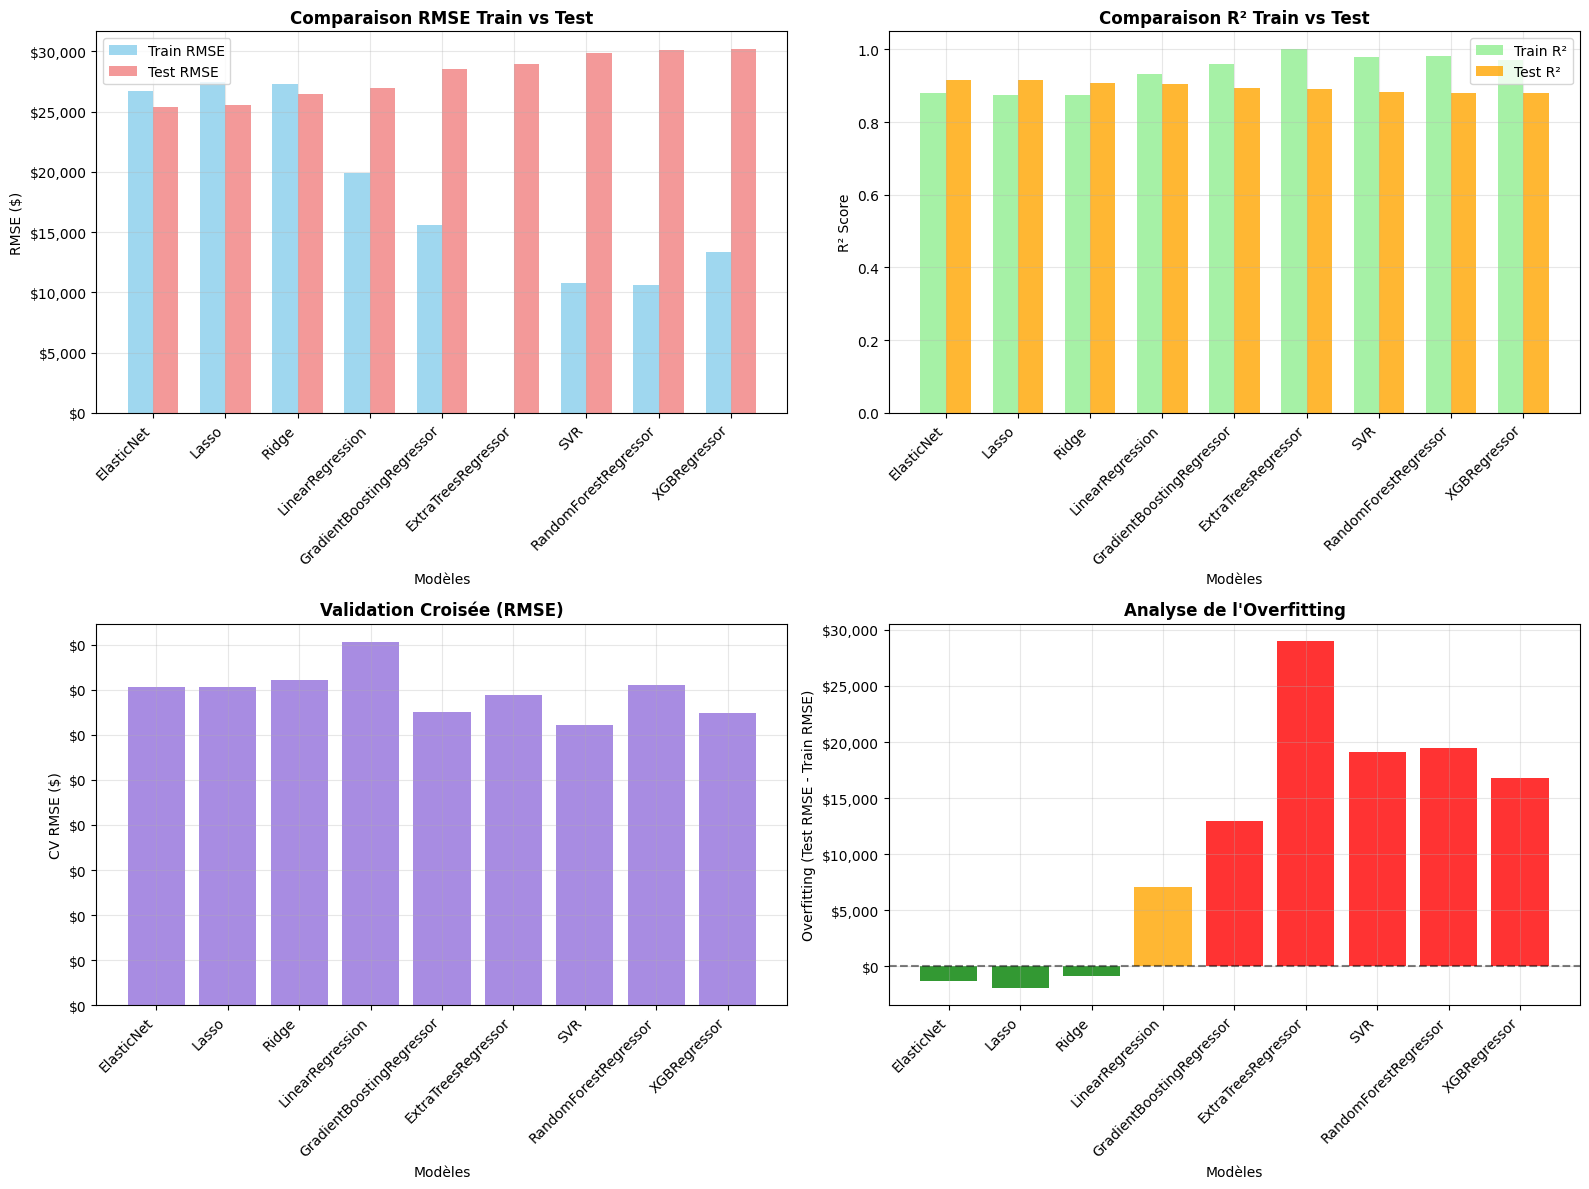

2025-07-31 23:19:04.059 | INFO     | __main__:<module>:166 - Comparaison terminée. Meilleur modèle: ElasticNet (RMSE: $25,422.81)



Top 3 des modèles pour analyse multi-critères:
1. ElasticNet - RMSE: $25,423, R²: 0.916
2. Lasso - RMSE: $25,536, R²: 0.915
3. Ridge - RMSE: $26,505, R²: 0.908

Tableau de comparaison sauvegardé: d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_models_comparison.csv


In [12]:
print("\n=== COMPARAISON DES RÉSULTATS ===")

if len(results) == 0:
    print("Aucun modèle n'a été entraîné avec succès.")
    logger.error("Aucun résultat disponible pour la comparaison")
else:
    # Création du DataFrame de comparaison à partir de votre structure results
    results_df = pd.DataFrame(results).sort_values(by="Test RMSE")

    # Ajout de la colonne overfitting
    results_df["Overfitting"] = results_df["Test RMSE"] - results_df["Train RMSE"]

    print("\nTableau de comparaison des modèles:")
    # Formatage pour l'affichage
    display_df = results_df.copy()
    display_df["CV RMSE"] = display_df["CV RMSE"].apply(lambda x: f"${x:,.2f}")
    display_df["Train RMSE"] = display_df["Train RMSE"].apply(lambda x: f"${x:,.2f}")
    display_df["Train MAE"] = display_df["Train MAE"].apply(lambda x: f"${x:,.2f}")
    display_df["Test RMSE"] = display_df["Test RMSE"].apply(lambda x: f"${x:,.2f}")
    display_df["Test MAE"] = display_df["Test MAE"].apply(lambda x: f"${x:,.2f}")
    display_df["Train MAPE"] = display_df["Train MAPE"].apply(lambda x: f"{x:.2f}%")
    display_df["Test MAPE"] = display_df["Test MAPE"].apply(lambda x: f"{x:.2f}%")
    display_df["Train R2"] = display_df["Train R2"].apply(lambda x: f"{x:.4f}")
    display_df["Test R2"] = display_df["Test R2"].apply(lambda x: f"{x:.4f}")
    display_df["Overfitting"] = display_df["Overfitting"].apply(lambda x: f"${x:,.2f}")

    print(
        display_df[
            [
                "Model",
                "CV RMSE",
                "Train RMSE",
                "Test RMSE",
                "Train R2",
                "Test R2",
                "Test MAE",
                "Test MAPE",
                "Overfitting",
            ]
        ].to_string(index=False)
    )

    # Identification du meilleur modèle
    best_model_row = results_df.iloc[0]
    best_model_name = best_model_row["Model"]
    best_model_rmse = best_model_row["Test RMSE"]
    best_model_r2 = best_model_row["Test R2"]

    print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
    print(f"   Test RMSE: ${best_model_rmse:,.2f}")
    print(f"   Test R²: {best_model_r2:.4f}")
    print(f"   Test MAE: ${best_model_row['Test MAE']:,.2f}")
    print(f"   Test MAPE: {best_model_row['Test MAPE']:.2f}%")

    # Visualisations comparatives
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Comparaison RMSE Train vs Test
    x_pos = np.arange(len(results_df))
    width = 0.35

    axes[0, 0].bar(
        x_pos - width / 2,
        results_df["Train RMSE"],
        width,
        label="Train RMSE",
        alpha=0.8,
        color="skyblue",
    )
    axes[0, 0].bar(
        x_pos + width / 2,
        results_df["Test RMSE"],
        width,
        label="Test RMSE",
        alpha=0.8,
        color="lightcoral",
    )
    axes[0, 0].set_xlabel("Modèles")
    axes[0, 0].set_ylabel("RMSE ($)")
    axes[0, 0].set_title("Comparaison RMSE Train vs Test", fontweight="bold")
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Formatage de l'axe Y en dollars
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

    # 2. Comparaison R² Train vs Test
    axes[0, 1].bar(
        x_pos - width / 2,
        results_df["Train R2"],
        width,
        label="Train R²",
        alpha=0.8,
        color="lightgreen",
    )
    axes[0, 1].bar(
        x_pos + width / 2,
        results_df["Test R2"],
        width,
        label="Test R²",
        alpha=0.8,
        color="orange",
    )
    axes[0, 1].set_xlabel("Modèles")
    axes[0, 1].set_ylabel("R² Score")
    axes[0, 1].set_title("Comparaison R² Train vs Test", fontweight="bold")
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Validation croisée (CV RMSE)
    axes[1, 0].bar(
        x_pos,
        results_df["CV RMSE"],
        alpha=0.8,
        color="mediumpurple",
    )
    axes[1, 0].set_xlabel("Modèles")
    axes[1, 0].set_ylabel("CV RMSE ($)")
    axes[1, 0].set_title("Validation Croisée (RMSE)", fontweight="bold")
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[1, 0].grid(True, alpha=0.3)

    # Formatage de l'axe Y en dollars
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

    # 4. Analyse de l'overfitting
    colors = [
        "green" if x < 5000 else "orange" if x < 10000 else "red"
        for x in results_df["Overfitting"]
    ]
    axes[1, 1].bar(x_pos, results_df["Overfitting"], alpha=0.8, color=colors)
    axes[1, 1].set_xlabel("Modèles")
    axes[1, 1].set_ylabel("Overfitting (Test RMSE - Train RMSE)")
    axes[1, 1].set_title("Analyse de l'Overfitting", fontweight="bold")
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(results_df["Model"], rotation=45, ha="right")
    axes[1, 1].axhline(y=0, color="black", linestyle="--", alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    # Formatage de l'axe Y en dollars
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

    plt.tight_layout()
    plt.show()

    # Graphique radar pour comparaison multi-critères des top 3
    if len(results_df) >= 3:
        top_3_models = results_df.head(3)

        print("\nTop 3 des modèles pour analyse multi-critères:")
        for i, (_, row) in enumerate(top_3_models.iterrows()):
            print(
                f"{i+1}. {row['Model']} - RMSE: ${row['Test RMSE']:,.0f}, R²: {row['Test R2']:.3f}"
            )

    # Sauvegarde des résultats de comparaison
    comparison_file = OUTPUT_DIR / "house_price_models_comparison.csv"
    results_df.to_csv(comparison_file, index=False)
    print(f"\nTableau de comparaison sauvegardé: {comparison_file}")

    logger.info(
        f"Comparaison terminée. Meilleur modèle: {best_model_name} (RMSE: ${best_model_rmse:,.2f})"
    )

Les graphiques et le tableau confirment la sélection du modèle ElasticNet.

La comparaison RMSE,montre que les modèles linéaires (ElasticNet, Lasso, Ridge) ont les barres de Test RMSE les plus basses. Il met aussi en évidence l'écart important entre l'erreur d'entraînement et de test pour les modèles complexes comme ExtraTreesRegressor, ce qui confirme leur surapprentissage.

L'analyse de l'overfitting quantifie cet écart. Les modèles linéaires ont des barres vertes (faible surapprentissage), tandis que les modèles ensemblistes (RandomForest, XGBoost, etc.) ont des barres rouges, indiquant qu'ils sont beaucoup moins performants sur les nouvelles données que sur celles vues à l'entraînement.

Finalement, le modèle ElasticNet est retenu car il présente le meilleur équilibre. En effet, il a une faible erreur de prédiction sur les données de test (25,423 $) et une très bonne capacité de généralisation.

### Analyse approfondie du meilleur modèle

Le choix d'un modèle ne se limite pas à ses métriques de performance. Il est essentiel de valider ses hypothèses. Cette section se concentre donc sur l'analyse des résidus du meilleur modèle pour vérifier leur normalité et s'assurer qu'ils sont distribués de manière aléatoire.


=== ANALYSE APPROFONDIE DU MEILLEUR MODÈLE ===
Analyse détaillée du modèle: ElasticNet


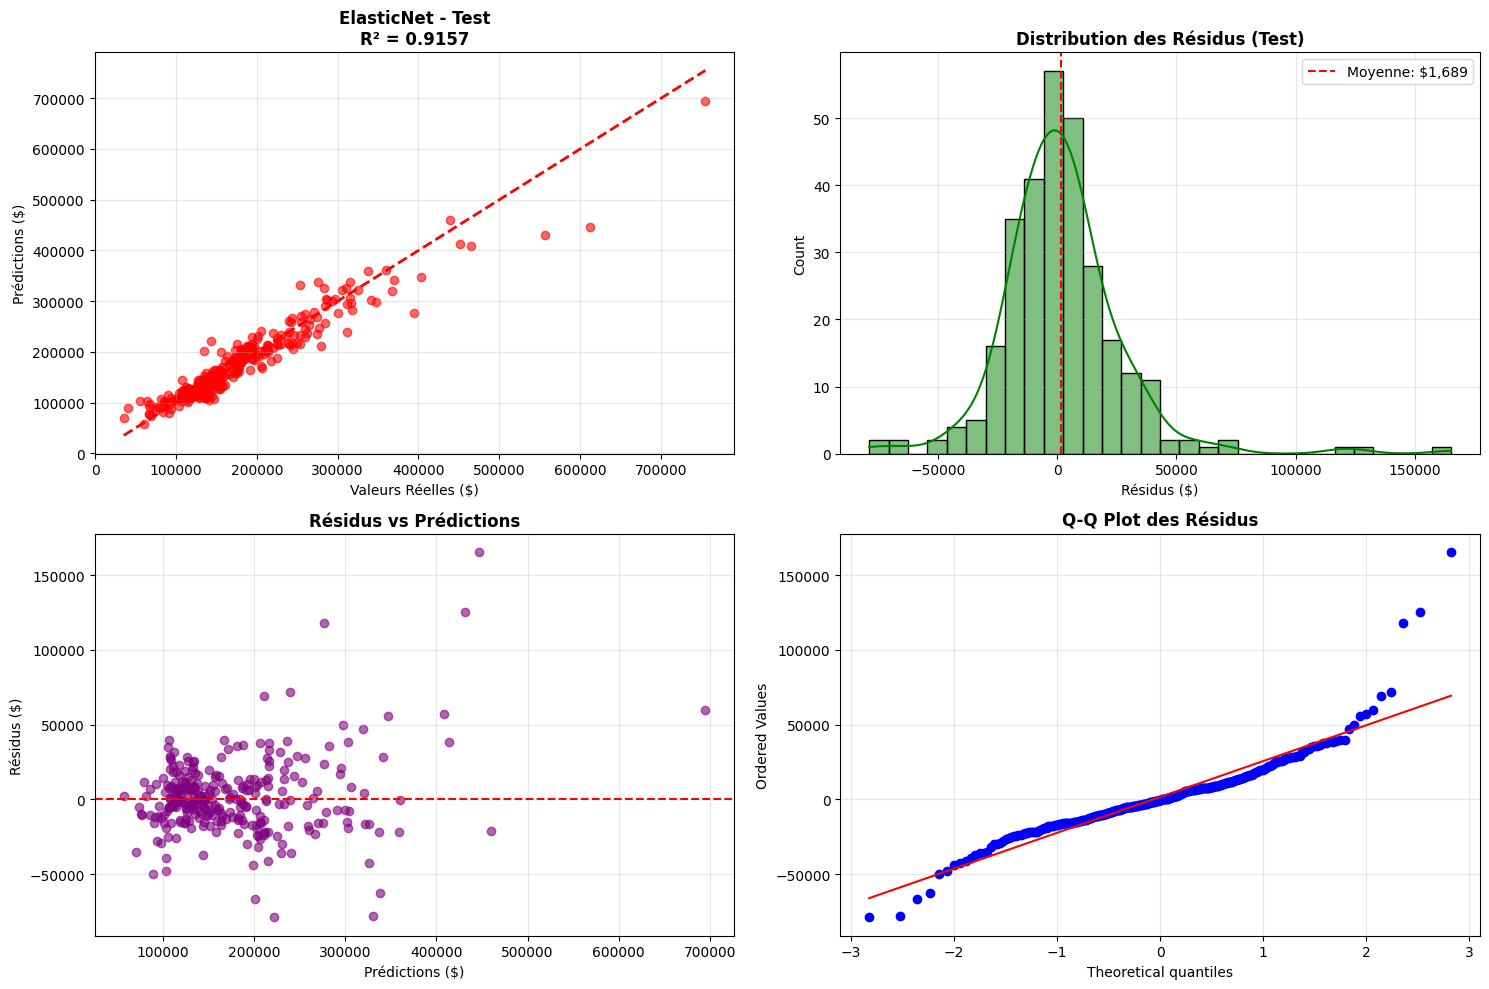

2025-07-31 23:19:12.567 | INFO     | __main__:<module>:83 - Analyse du meilleur modèle terminée. Résidus moyens: $1,689


In [13]:
print("\n=== ANALYSE APPROFONDIE DU MEILLEUR MODÈLE ===")

# S'assurer que les variables des cellules précédentes sont disponibles
if "best_model" in locals() and best_model is not None:
    # A ce stade, la variable 'best_model' contient l'objet estimateur (pipeline)
    # final_model_estimator = best_model
    final_model_estimator = best_model["estimator"]

    # Le nom 'best_model_name' a été défini dans la cellule de comparaison
    print(f"Analyse détaillée du modèle: {best_model_name}")

    # Trouver le dictionnaire de résultats pour le meilleur modèle en utilisant son nom
    best_model_metrics = next(
        (item for item in results if item["Model"] == best_model_name), None
    )

    if best_model_metrics:
        # Les prédictions sont recalculées avec le meilleur estimateur
        y_train_pred_best = final_model_estimator.predict(X_train)
        y_test_pred_best = final_model_estimator.predict(X_test)

        # Reconversion si la transformation log a été utilisée
        if use_log_transform:
            y_train_orig = np.expm1(y_train)
            y_test_orig = np.expm1(y_test)
            y_train_pred_orig = np.expm1(y_train_pred_best)
            y_test_pred_orig = np.expm1(y_test_pred_best)
        else:
            y_train_orig = y_train
            y_test_orig = y_test
            y_train_pred_orig = y_train_pred_best
            y_test_pred_orig = y_test_pred_best

        # Visualisations détaillées
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Prédictions vs Valeurs réelles (Test)
        axes[0, 0].scatter(y_test_orig, y_test_pred_orig, alpha=0.6, color="red")
        axes[0, 0].plot(
            [y_test_orig.min(), y_test_orig.max()],
            [y_test_orig.min(), y_test_orig.max()],
            "r--",
            lw=2,
        )
        axes[0, 0].set_xlabel("Valeurs Réelles ($)")
        axes[0, 0].set_ylabel("Prédictions ($)")
        axes[0, 0].set_title(
            f'{best_model_name} - Test\nR² = {best_model_metrics["Test R2"]:.4f}',
            fontweight="bold",
        )
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Distribution des résidus (Test)
        residuals_test = y_test_orig - y_test_pred_orig
        sns.histplot(residuals_test, bins=30, kde=True, ax=axes[0, 1], color="green")
        axes[0, 1].axvline(
            residuals_test.mean(),
            color="red",
            linestyle="--",
            label=f"Moyenne: ${residuals_test.mean():,.0f}",
        )
        axes[0, 1].set_xlabel("Résidus ($)")
        axes[0, 1].set_title("Distribution des Résidus (Test)", fontweight="bold")
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Résidus vs Prédictions
        axes[1, 0].scatter(y_test_pred_orig, residuals_test, alpha=0.6, color="purple")
        axes[1, 0].axhline(y=0, color="red", linestyle="--")
        axes[1, 0].set_xlabel("Prédictions ($)")
        axes[1, 0].set_ylabel("Résidus ($)")
        axes[1, 0].set_title("Résidus vs Prédictions", fontweight="bold")
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Q-Q plot des résidus
        stats.probplot(residuals_test, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title("Q-Q Plot des Résidus", fontweight="bold")
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        logger.info(
            f"Analyse du meilleur modèle terminée. Résidus moyens: ${residuals_test.mean():,.0f}"
        )
    else:
        print("Erreur: Impossible de trouver les métriques pour le meilleur modèle.")
        logger.error(f"Métriques non trouvées pour le modèle {best_model_name}")
else:
    print("Aucun modèle disponible pour l'analyse.")
    logger.error("Aucun modèle disponible pour l'analyse approfondie")

Ces graphiques permettent de valider le comportement du modèle ElasticNet.

- Prédictions vs Valeurs Réelles : Les points sont bien alignés sur la ligne diagonale, ce qui montre que les prédictions du modèle sont proches des prix réels.

- Distribution des Résidus : L'histogramme a une forme de cloche centrée sur zéro. Cela signifie que les erreurs sont normalement distribuées et qu'il n'y a pas de biais systématique (le modèle ne surestime ou ne sous-estime pas constamment).

- Résidus vs Prédictions : Les points d'erreur sont dispersés de manière aléatoire autour de la ligne horizontale. Il n'y a pas de structure (comme un entonnoir), ce qui indique que la performance du modèle est constante, quel que soit le prix de la maison.

- Q-Q Plot: Les points suivent la ligne rouge, ce qui confirme une fois de plus la normalité des erreurs.

L'ensemble de ces observations indique que le modèle est fiable et que ses résultats sont statistiquement valides.

### Analyse de l'importance des features

Pour rendre notre modèle interprétable, nous analysons ici l'importance des variables. Cela nous permet de comprendre quels facteurs influencent le plus les prix des maisons. L'analyse portera sur les coefficients du modèle pour identifier les principaux leviers de prix.


=== ANALYSE DE L'IMPORTANCE DES FEATURES ===
Top 20 des coefficients les plus importants (hors modalités rares) pour ElasticNet:
                        feature  coefficient  abs_coefficient  frequency
2                num__GrLivArea     0.091545         0.091545   1.000000
87     cat__Exterior1st_BrkFace     0.089171         0.089171   0.034247
8             num__QualityScore     0.071914         0.071914   1.000000
19             cat__MSZoning_RM    -0.067132         0.067132   0.147260
1                  num__TotalSF     0.060309         0.060309   1.000000
186         cat__Functional_Typ     0.057633         0.057633   0.928082
129            cat__BsmtQual_Ex     0.057316         0.057316   0.083048
169           cat__CentralAir_N    -0.057040         0.057040   0.071062
176         cat__KitchenQual_Ex     0.055223         0.055223   0.065925
3               num__GarageCars     0.054994         0.054994   1.000000
0              num__OverallQual     0.054022         0.054022   1.0

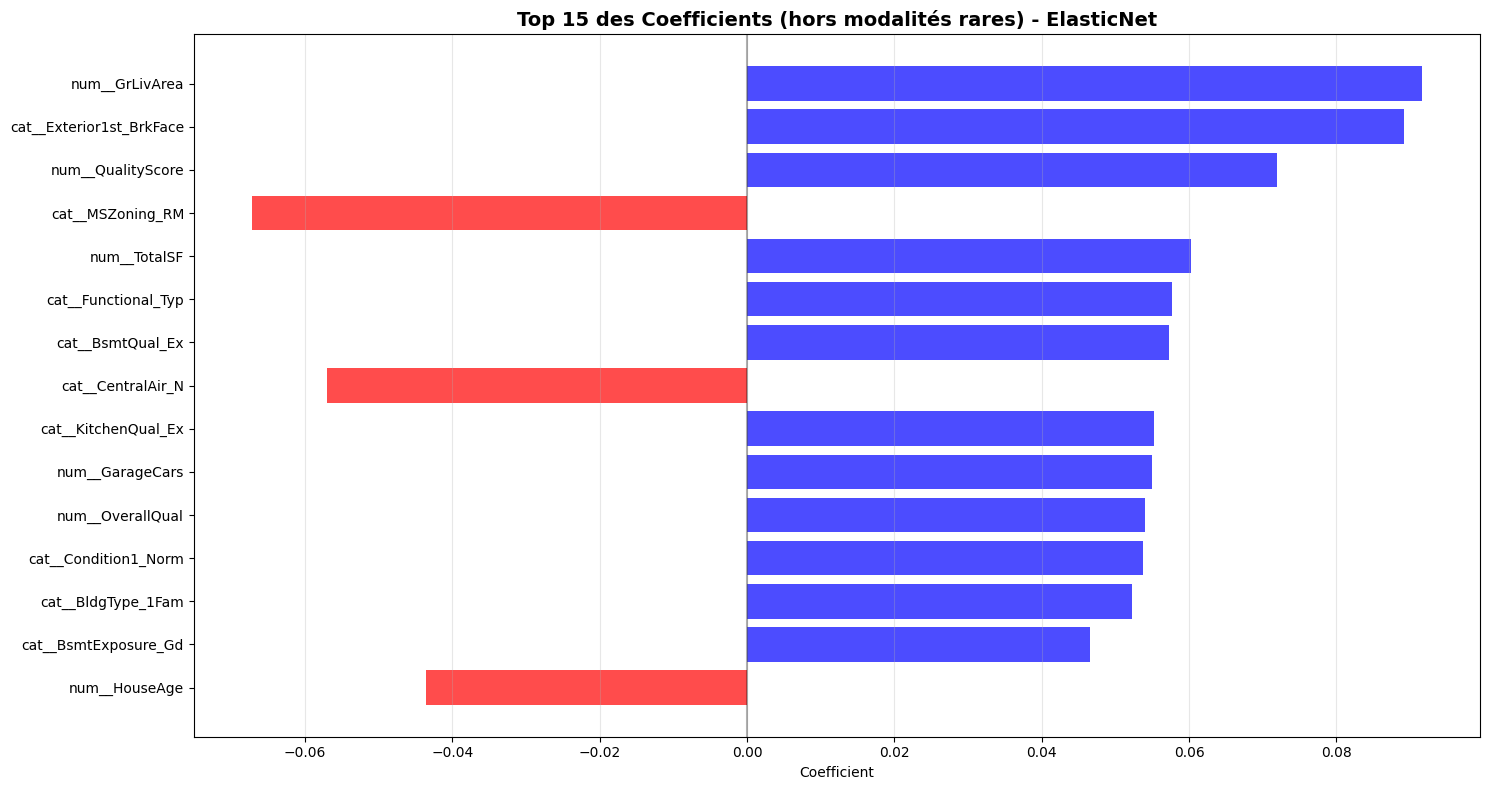

2025-07-31 23:54:15.851 | INFO     | __main__:<module>:79 - Analyse des coefficients terminée (hors modalités rares). Top coefficient: num__GrLivArea (0.0915)



Coefficients sauvegardés (hors modalités rares): d:\Documents\IT\mlops_house_price_prediction\notebooks\output_files\house_price_02_essais_coefficients_ElasticNet_filtered.csv


In [24]:
print("\n=== ANALYSE DE L'IMPORTANCE DES FEATURES ===")


def get_feature_frequencies(X, preprocessor, feature_names):
    """
    Retourne un dict {feature_name: fréquence} pour les features issues du OneHotEncoder.
    Pour les features numériques, la fréquence est 1.
    """
    freq_dict = {}
    for name in feature_names:
        if name.startswith("cat__"):
            try:
                col, val = name.replace("cat__", "").split("_", 1)
                if col in X.columns:
                    freq = (X[col] == val).mean()
                    freq_dict[name] = freq
                else:
                    freq_dict[name] = 0
            except Exception:
                freq_dict[name] = 0
        else:
            freq_dict[name] = 1  # numérique
    return freq_dict


if len(results) > 0 and hasattr(best_model["estimator"].named_steps["model"], "coef_"):
    # Récupération des noms de features après preprocessing
    if hasattr(
        best_model["estimator"].named_steps["preprocessor"], "get_feature_names_out"
    ):
        all_feature_names = (
            best_model["estimator"].named_steps["preprocessor"].get_feature_names_out()
        )
        all_feature_names = [str(f) for f in all_feature_names]
    else:
        all_feature_names = selected_features

    coefficients = best_model["estimator"].named_steps["model"].coef_

    # Calcul des fréquences pour filtrer les modalités rares
    freq_dict = get_feature_frequencies(
        X_train, best_model["estimator"].named_steps["preprocessor"], all_feature_names
    )
    coef_df = pd.DataFrame(
        {
            "feature": all_feature_names,
            "coefficient": coefficients,
            "abs_coefficient": np.abs(coefficients),
            "frequency": [freq_dict.get(f, 1) for f in all_feature_names],
        }
    )

    # Filtrer les modalités trop rares (<1% des données)
    coef_df_filtered = coef_df[coef_df["frequency"] > 0.01]

    # Trier par importance absolue
    coef_df_filtered = coef_df_filtered.sort_values("abs_coefficient", ascending=False)

    print(
        f"Top 20 des coefficients les plus importants (hors modalités rares) pour {best_model_name}:"
    )
    print(coef_df_filtered.head(20))

    # Visualisation
    plt.figure(figsize=FIGSIZE_LARGE)
    top_coefs = coef_df_filtered.head(15)
    colors = ["red" if x < 0 else "blue" for x in top_coefs["coefficient"]]
    plt.barh(range(len(top_coefs)), top_coefs["coefficient"], color=colors, alpha=0.7)
    plt.yticks(range(len(top_coefs)), top_coefs["feature"])
    plt.xlabel("Coefficient")
    plt.title(
        f"Top 15 des Coefficients (hors modalités rares) - {best_model_name}",
        fontweight="bold",
        fontsize=14,
    )
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    plt.show()

    # Sauvegarde des coefficients filtrés
    coef_file = (
        OUTPUT_DIR
        / f"house_price_02_essais_coefficients_{best_model_name}_filtered.csv"
    )
    coef_df_filtered.to_csv(coef_file, index=False)
    print(f"\nCoefficients sauvegardés (hors modalités rares): {coef_file}")

    logger.info(
        f"Analyse des coefficients terminée (hors modalités rares). Top coefficient: {coef_df_filtered.iloc[0]['feature']} ({coef_df_filtered.iloc[0]['coefficient']:.4f})"
    )

else:
    print("Aucun modèle disponible pour l'analyse des features ou modèle non linéaire.")
    logger.error("Aucun modèle disponible pour l'analyse des features")

Cette analyse montre quels facteurs le modèle ElasticNet a identifiés comme les plus importants pour déterminer le prix d'une maison. Le graphique affiche les "coefficients" associés à chaque variable : en bleu, ce qui augmente le prix, et en rouge, ce qui le diminue.

Les facteurs qui augmentent le plus la valeur sont, logiquement, la surface habitable (GrLivArea), la qualité générale (OverallQual) et le nombre de places de garage (GarageCars).

À l'inverse, être dans une zone résidentielle de moyenne densité (MSZoning_RM) ou avoir une condition de vente anormale (SaleCondition_Abnorml) sont des facteurs qui ont un impact négatif sur le prix. Ces résultats confirment que le modèle a appris des relations cohérentes avec la logique du marché immobilier.

### Sauvegarde du modèle final et préparation pour le déploiement

La dernière étape consiste à sauvegarder notre travail pour un usage futur. Nous allons enregistrer le pipeline de modèle final et les métadonnées associées. Cela nous permettra de le déployer facilement dans une autre application pour faire des prédictions sur de nouvelles données.

In [25]:
print("\n=== SAUVEGARDE DU MODÈLE FINAL ===")

if len(results) > 0:
    # Sauvegarde du meilleur modèle avec pickle
    model_file = MODELS_DIR / f"house_price_best_model_{best_model_name.lower()}.pkl"

    with open(model_file, "wb") as f:
        pickle.dump(best_model, f)

    print(f"Meilleur modèle sauvegardé: {model_file}")

    # Récupération des métriques du meilleur modèle
    best_model_row = results_df[results_df["Model"] == best_model_name].iloc[0]

    # Sauvegarde des métadonnées du modèle
    model_metadata = {
        "model_name": best_model_name,
        "model_type": type(best_model["estimator"].named_steps["model"]).__name__,
        "training_date": CURRENT_DATE.isoformat(),
        "target_variable": TARGET_VARIABLE,
        "use_log_transform": use_log_transform,
        "features": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
            "total_features": len(selected_features),
            "final_features_count": len(all_feature_names),
        },
        "performance": {
            "test_rmse": float(best_model_row["Test RMSE"]),
            "test_r2": float(best_model_row["Test R2"]),
            "test_mae": float(best_model_row["Test MAE"]),
            "test_mape": float(best_model_row["Test MAPE"]),
            "cv_rmse_mean": float(best_model_row["CV RMSE"]),
            "cv_rmse_std": float(
                "nan"
            ),  # À remplacer si tu calcules l'écart-type du CV
        },
        "data_info": {
            "train_size": X_train.shape[0],
            "test_size": X_test.shape[0],
            "total_size": len(X_selected),
        },
        "preprocessing": {
            "numeric_imputation": "median",
            "numeric_scaling": "RobustScaler",
            "categorical_imputation": "most_frequent",
            "categorical_encoding": "OneHotEncoder",
        },
    }

    metadata_file = (
        MODELS_DIR / f"house_price_best_model_{best_model_name.lower()}_metadata.json"
    )
    with open(metadata_file, "w") as f:
        json.dump(model_metadata, f, indent=2)

    print(f"Métadonnées du modèle sauvegardées: {metadata_file}")

    # Création d'un fichier de prédiction d'exemple
    example_data = X_test.head(5).copy()
    example_predictions = best_model["estimator"].predict(example_data)

    if use_log_transform:
        example_predictions_orig = np.expm1(example_predictions)
        example_actual_orig = np.expm1(y_test.head(5))
    else:
        example_predictions_orig = example_predictions
        example_actual_orig = y_test.head(5)

    example_results = pd.DataFrame(
        {
            "Actual_Price": example_actual_orig,
            "Predicted_Price": example_predictions_orig,
            "Absolute_Error": np.abs(example_actual_orig - example_predictions_orig),
            "Percentage_Error": np.abs(example_actual_orig - example_predictions_orig)
            / example_actual_orig
            * 100,
        }
    )

    # Ajout des features principales pour contexte
    main_features = (
        ["GrLivArea", "OverallQual", "YearBuilt"]
        if all(
            f in example_data.columns for f in ["GrLivArea", "OverallQual", "YearBuilt"]
        )
        else example_data.columns[:3]
    )
    for feature in main_features:
        if feature in example_data.columns:
            example_results[feature] = example_data[feature].values

    example_file = OUTPUT_DIR / "house_price_02_essais_predictions_exemple.csv"
    example_results.to_csv(example_file, index=False)

    print("\nExemples de prédictions:")
    print(example_results.round(2))
    print(f"\nExemples de prédictions sauvegardés: {example_file}")

    # Résumé final
    print(f"\n{'='*80}")
    print("RÉSUMÉ DE L'EXPÉRIMENTATION")
    print(f"{'='*80}")
    print(f"Modèles testés: {len(results)}")
    print(f"Meilleur modèle: {best_model_name}")
    print("Performance (Test):")
    print(f"  - RMSE: ${best_model_row['Test RMSE']:,.2f}")
    print(f"  - R²: {best_model_row['Test R2']:.4f}")
    print(f"  - MAE: ${best_model_row['Test MAE']:,.2f}")
    print(f"  - MAPE: {best_model_row['Test MAPE']:.2f}%")
    print("Validation croisée:")
    print(f"  - CV RMSE: ${best_model_row['CV RMSE']:,.2f} (écart-type non calculé)")
    print(
        f"Features utilisées: {len(selected_features)} → {len(all_feature_names)} (après preprocessing)"
    )
    print(f"Transformation log: {'Oui' if use_log_transform else 'Non'}")

    # Instructions pour le déploiement
    print(f"\n{'='*80}")
    print("INSTRUCTIONS POUR LE DÉPLOIEMENT")
    print(f"{'='*80}")
    print(f"1. Modèle sauvegardé: {model_file}")
    print(f"2. Métadonnées: {metadata_file}")
    print("3. Pour charger le modèle:")
    print(f"   with open('{model_file}', 'rb') as f:")
    print("       model = pickle.load(f)")
    print("4. Pour faire une prédiction:")
    print("   prediction = model.predict(new_data)")
    if use_log_transform:
        print("   price = np.expm1(prediction)  # Reconversion depuis log")
    print(f"5. Features requises: {len(selected_features)} variables")
    print(f"   - Numériques: {numeric_features[:5]}...")
    print(f"   - Catégorielles: {categorical_features[:3]}...")

    logger.info(
        f"Modèle final sauvegardé: {best_model_name} (RMSE: ${best_model_row['Test RMSE']:,.2f})"
    )

else:
    print("Aucun modèle à sauvegarder.")
    logger.error("Aucun modèle disponible pour la sauvegarde")

print(f"\n{'='*80}")
print("EXPÉRIMENTATION TERMINÉE AVEC SUCCÈS")
print(f"{'='*80}")

logger.info("Expérimentation terminée avec succès")

2025-07-31 23:54:20.867 | INFO     | __main__:<module>:135 - Modèle final sauvegardé: ElasticNet (RMSE: $25,422.81)
2025-07-31 23:54:20.874 | INFO     | __main__:<module>:147 - Expérimentation terminée avec succès



=== SAUVEGARDE DU MODÈLE FINAL ===
Meilleur modèle sauvegardé: d:\Documents\IT\mlops_house_price_prediction\notebooks\models\house_price_best_model_elasticnet.pkl
Métadonnées du modèle sauvegardées: d:\Documents\IT\mlops_house_price_prediction\notebooks\models\house_price_best_model_elasticnet_metadata.json

Exemples de prédictions:
      Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error  \
892       154500.0        154050.60          449.40              0.29   
1105      325000.0        321005.09         3994.91              1.23   
413       115000.0        105082.36         9917.64              8.62   
522       159000.0        152480.48         6519.52              4.10   
1036      315500.0        337452.31        21952.31              6.96   

      GrLivArea  OverallQual  YearBuilt  
892        1068            6       1963  
1105       2622            8       1994  
413        1028            5       1927  
522        1664            6       1947  
1036       1620

Cette dernière étape finalise l'expérimentation.

Le modèle ElasticNet a été sauvegardé dans un fichier .pkl. Il est maintenant prêt pour de futures prédictions. Un fichier de métadonnées .json a aussi été créé. Il contient toutes les informations importantes du modèle, comme son RMSE de 26,604 $.

Des instructions claires sont fournies. Elles expliquent comment charger et utiliser ce modèle. Le processus est maintenant terminé.